In [1]:
# Import necessary modules
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.functions import (
    col,
    count,
    from_unixtime,
    isnan,
    regexp_extract,
    split,
)
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import to_timestamp, udf, unix_timestamp, when
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.window import Window

# Set up matplotlib to work in Jupyter notebooks
%matplotlib inline

In [2]:
# Create SparkContext, SQLContext, and SparkSession objects

sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/30 15:07:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/aditshrimal/opt/anaconda3/envs/DistributedDataSystems/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:

# Print the SparkSession

spark

In [4]:
# rdd = sc.textFile("/Users/aditshrimal/Desktop/MSDS/summer23/assignments/log-analytics/dataset/NASA_access_log_Aug95.gz")
# rdd.take(5)

In [5]:
# Load the data into a DataFrame

df = spark.read.text(
    "/Users/aditshrimal/Desktop/MSDS/summer23/assignments/log-analytics/dataset/NASA_access_log_Aug95.gz"
)

# df2 = spark.read.text(
#     "/Users/aditshrimal/Desktop/MSDS/summer23/assignments/log-analytics/dataset/NASA_access_log_Jul95.gz"
# )

# df = df1.union(df2)

In [6]:
df.show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839|
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                   |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                          |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0                           |


The logs are an ASCII file with one line per request, with the following columns:
1. host making the request. A hostname when possible, otherwise the Internet address if the name could not be looked up.
2. timestamp in the format "DAY MON DD HH:MM:SS YYYY", where DAY is the day of the week, MON is the name of the month, DD is the day of the month, HH:MM:SS is the time of day using a 24-hour clock, and YYYY is the year. The timezone is -0400.
3. request given in quotes.
4. HTTP reply code.
5. bytes in the reply.

In [7]:
# Parse the log data into separate columns

df_parsed = df.select(
    regexp_extract("value", r"^([^\s]+\s)", 1).alias("host"),
    regexp_extract(
        "value", r"^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]", 1
    ).alias("timestamp"),
    regexp_extract("value", r'^.*"\s*(\w+)\s+([^\s]+)\s+([^\s]+)"', 1).alias("method"),
    regexp_extract("value", r'^.*"\s*(\w+)\s+([^\s]+)\s+([^\s]+)"', 2).alias(
        "endpoint"
    ),
    regexp_extract("value", r'^.*"\s*(\w+)\s+([^\s]+)\s+([^\s]+)"', 3).alias(
        "protocol"
    ),
    regexp_extract("value", r'^.*"\s+([^\s]+)', 1).cast("integer").alias("status"),
    regexp_extract("value", r"^.*\s+(\d+)$", 1).cast("integer").alias("content_size"),
)

In [8]:
df_parsed.show(5, truncate=False)

+------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|host              |timestamp                 |method|endpoint                                       |protocol|status|content_size|
+------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|in24.inetnebr.com |01/Aug/1995:00:00:01 -0400|GET   |/shuttle/missions/sts-68/news/sts-68-mcc-05.txt|HTTP/1.0|200   |1839        |
|uplherc.upl.com   |01/Aug/1995:00:00:07 -0400|GET   |/                                              |HTTP/1.0|304   |0           |
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|GET   |/images/ksclogo-medium.gif                     |HTTP/1.0|304   |0           |
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|GET   |/images/MOSAIC-logosmall.gif                   |HTTP/1.0|304   |0           |
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|GET   |/images/USA-logosmall.

In [9]:
# Define a function to count the number of null values in a column

def count_null(col_name):
    return df_parsed.filter(col(col_name).isNull()).count()

# Count the number of null values in each column
exprs = {col_name: count_null(col_name) for col_name in df_parsed.columns}

exprs

{'host': 0,
 'timestamp': 0,
 'method': 0,
 'endpoint': 0,
 'protocol': 0,
 'status': 0,
 'content_size': 14178}

In [10]:
# Identify the rows where the content_size is null

null_content_size_df = df.filter(~df["value"].rlike(r"\s\d+$"))
null_content_size_df.count()

14178

In [11]:
null_content_size_df.take(10)

[Row(value='gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -'),
 Row(value='js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -'),
 Row(value='tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -'),
 Row(value='itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -'),
 Row(value='grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -'),
 Row(value='miriworld.its.unimelb.edu.au - - [01/Aug/1995:01:04:54 -0400] "GET /history/history.htm HTTP/1.0" 404 -'),
 Row(value='ras38.srv.net - - [01/Aug/1995:01:05:14 -0400] "GET /elv/DELTA/uncons.htm HTTP/1.0" 404 -'),
 Row(value='cs1-06.leh.ptd.net - - [01/Aug/1995:01:17:38 -0400] "GET /sts-71/launch/" 404 -'),
 Row(value='www-b2.proxy.aol.com - - [01/Aug/1995:01:22:07 -0400] "GET 

### Fixing the rows with null content_size

In [12]:
# Replace the null values in the content_size column with 0

df_parsed = df_parsed.na.fill({"content_size": 0})

In [13]:
# Count the number of null values in each column after the replacement

exprs = {col_name: count_null(col_name) for col_name in df_parsed.columns}
exprs

{'host': 0,
 'timestamp': 0,
 'method': 0,
 'endpoint': 0,
 'protocol': 0,
 'status': 0,
 'content_size': 0}

### Handling Temporal Fields (Timestamp)

In [14]:
# Define a function to convert the string to timestamp
def parse_date(df, column, pattern):
    return df.withColumn(column, from_unixtime(unix_timestamp(df[column], pattern)))

In [15]:
# Specify the date pattern

date_pattern = "dd/MMM/yyyy:HH:mm:ss"

In [16]:
# Create a mapping from month names to numbers

month_map = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12,
}

# Define a function to parse the timestamp string in the log data
def parse_clf_time(text):
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
        int(text[7:11]),
        month_map[text[3:6]],
        int(text[0:2]),
        int(text[12:14]),
        int(text[15:17]),
        int(text[18:20]),
    )

In [17]:
# Define a UDF (user-defined function) to parse the timestamp
udf_parse_time = udf(parse_clf_time, StringType())

In [18]:
# Set the time parser policy to "LEGACY"
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [19]:
# Convert timestamp column using UDF and then to_timestamp to get it into timestamp format
df_parsed = df_parsed.withColumn(
    "timestamp", to_timestamp(udf_parse_time(df_parsed["timestamp"]))
)

df_parsed.show(10, truncate=True)

+--------------------+-------------------+------+--------------------+--------+------+------------+
|                host|          timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+-------------------+------+--------------------+--------+------+------------+
|  in24.inetnebr.com |1995-08-01 00:00:01|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|
|    uplherc.upl.com |1995-08-01 00:00:07|   GET|                   /|HTTP/1.0|   304|           0|
|    uplherc.upl.com |1995-08-01 00:00:08|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|
|    uplherc.upl.com |1995-08-01 00:00:08|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|
|    uplherc.upl.com |1995-08-01 00:00:08|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|
|ix-esc-ca2-07.ix....|1995-08-01 00:00:09|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|
|    uplherc.upl.com |1995-08-01 00:00:10|   GET|/images/WORLD-log...|HTTP/1.0|   304|           0|


In [20]:
df_parsed.printSchema()

root
 |-- host: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)



In [21]:
# Cache the DataFrame to speed up subsequent operations
df_parsed.cache()

DataFrame[host: string, timestamp: timestamp, method: string, endpoint: string, protocol: string, status: int, content_size: int]

## Exploratory Data Analysis

### Content Size Analysis

In [22]:
df_parsed.filter(df_parsed['content_size']=='').show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
+----+---------+------+--------+--------+------+------------+



In [23]:
# Analyzing the 'content_size' field
content_size_summary_df = df_parsed.describe(["content_size"])
content_size_summary_df.toPandas()

,summary,content_size
0,count,1569898
1,mean,17089.225812122826
2,stddev,67954.76392156907
3,min,0
4,max,3421948


### HTTP Status Analysis

In [24]:
# Analyzing the HTTP Status Codes. We group by status and count
status_freq_df = df_parsed.groupBy("status").count().sort("status").cache()
print("Total distinct HTTP Status Codes:", status_freq_df.count())

Total distinct HTTP Status Codes: 8


In [25]:
# Convert status_freq_df to a pandas DataFrame and sort it by the count column
status_freq_pd_df = status_freq_df.toPandas().sort_values(by=["count"], ascending=False)
status_freq_pd_df

,status,count
0,200,1398988
2,304,134146
1,302,26497
5,404,10056
4,403,171
7,501,27
3,400,10
6,500,3


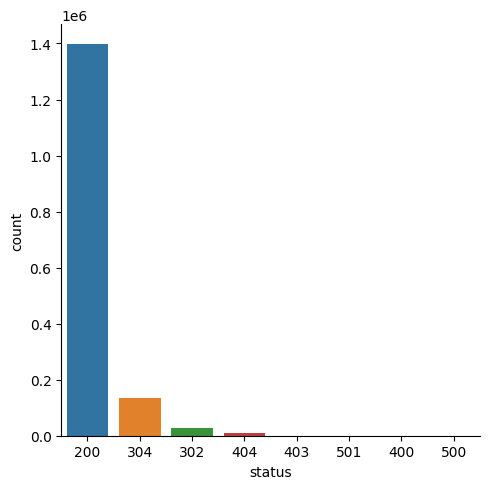

In [26]:
# Visualize the HTTP Status Codes
sns.catplot(
    x="status",
    y="count",
    data=status_freq_pd_df,
    kind="bar",
    order=status_freq_pd_df["status"],
)

#### Log transformation

In [27]:
# Applying a log transformation to visualize the data better
log_freq_df = status_freq_df.withColumn("log(count)", F.log(status_freq_df["count"]))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|1398988|14.151259676055433|
|   302|  26497|10.184786798018687|
|   304| 134146|11.806684038040606|
|   400|     10| 2.302585092994046|
|   403|    171|  5.14166355650266|
|   404|  10056| 9.215924750270084|
|   500|      3|1.0986122886681096|
|   501|     27| 3.295836866004329|
+------+-------+------------------+



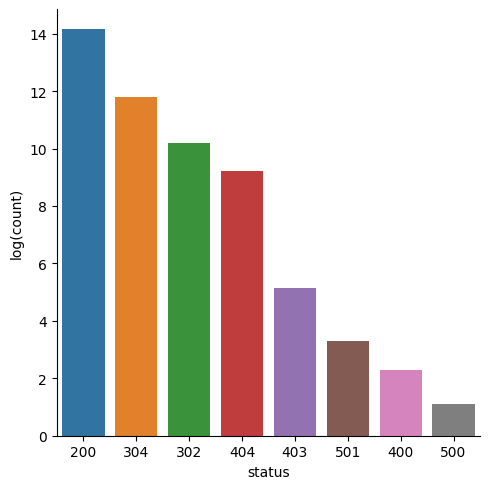

In [28]:
# Visualize the HTTP Status Codes after log transformation
log_freq_pd_df = log_freq_df.toPandas().sort_values(by=["log(count)"], ascending=False)
sns.catplot(
    x="status",
    y="log(count)",
    data=log_freq_pd_df,
    kind="bar",
    order=status_freq_pd_df["status"],
)

### Analyzing Frequent Hosts

In [29]:
# Analyze the top 10 hosts who accessed the web server the most
host_sum_df = df_parsed.groupBy("host").count().sort("count", ascending=False).limit(10)

host_sum_df.show(truncate=False)

+---------------------+-----+
|host                 |count|
+---------------------+-----+
|edams.ksc.nasa.gov   |6530 |
|piweba4y.prodigy.com |4846 |
|163.206.89.4         |4791 |
|piweba5y.prodigy.com |4607 |
|piweba3y.prodigy.com |4416 |
|www-d1.proxy.aol.com |3889 |
|www-b2.proxy.aol.com |3534 |
|www-b3.proxy.aol.com |3463 |
|www-c5.proxy.aol.com |3423 |
|www-b5.proxy.aol.com |3411 |
+---------------------+-----+



### Top 20 Frequent EndPoints

In [30]:
# Analyze the top 20 endpoints requested by the users
paths_df = (
    df_parsed.groupBy("endpoint").count().sort("count", ascending=False).limit(20)
)

paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,97267
1,/images/KSC-logosmall.gif,75278
2,/images/MOSAIC-logosmall.gif,67349
3,/images/USA-logosmall.gif,66968
4,/images/WORLD-logosmall.gif,66344
5,/images/ksclogo-medium.gif,62663
6,/ksc.html,43615
7,/history/apollo/images/apollo-logo1.gif,37804
8,/images/launch-logo.gif,35116
9,/,30101


### Top Ten Error Endpoints

In [31]:
# Identify the top 10 endpoints which resulted in an HTTP response other than 200
not200_df = df_parsed.filter(df_parsed["status"] != 200)

error_endpoints_freq_df = (
    not200_df.groupBy("endpoint").count().sort("count", ascending=False).limit(10)
)

error_endpoints_freq_df.show(truncate=False)

+----------------------------------------+-----+
|endpoint                                |count|
+----------------------------------------+-----+
|/images/NASA-logosmall.gif              |19072|
|/images/KSC-logosmall.gif               |11328|
|/images/MOSAIC-logosmall.gif            |8617 |
|/images/USA-logosmall.gif               |8565 |
|/images/WORLD-logosmall.gif             |8360 |
|/images/ksclogo-medium.gif              |7722 |
|/history/apollo/images/apollo-logo1.gif |4355 |
|/shuttle/countdown/images/countclock.gif|4227 |
|/images/launch-logo.gif                 |4178 |
|/                                       |3605 |
+----------------------------------------+-----+



### Total number of Unique Hosts

In [32]:
# Count the total number of unique hosts
unique_host_count = df_parsed.select("host").distinct().count()
unique_host_count

75060

### Number of Unique Daily Hosts

In [33]:
# Find the number of unique hosts in the entire log on a day-by-day basis
host_day_df = df_parsed.select(df_parsed.host, F.dayofmonth("timestamp").alias("day"))
host_day_df.show(5, truncate=False)

+------------------+---+
|host              |day|
+------------------+---+
|in24.inetnebr.com |1  |
|uplherc.upl.com   |1  |
|uplherc.upl.com   |1  |
|uplherc.upl.com   |1  |
|uplherc.upl.com   |1  |
+------------------+---+
only showing top 5 rows



In [34]:
# Visualize the daily_hosts_df DataFrame
host_day_distinct_df = host_day_df.dropDuplicates()
host_day_distinct_df.show(5, truncate=False)

+----------------+---+
|host            |day|
+----------------+---+
|149.156.238.11  |1  |
|130.206.110.5   |1  |
|128.159.154.153 |1  |
|128.217.61.101  |1  |
|130.239.219.149 |1  |
+----------------+---+
only showing top 5 rows



In [35]:
daily_hosts_df = host_day_distinct_df.groupBy("day").count().sort("day")

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,2582
1,3,3222
2,4,4191
3,5,2502
4,6,2538
5,7,4108
6,8,4406
7,9,4317
8,10,4523
9,11,4346


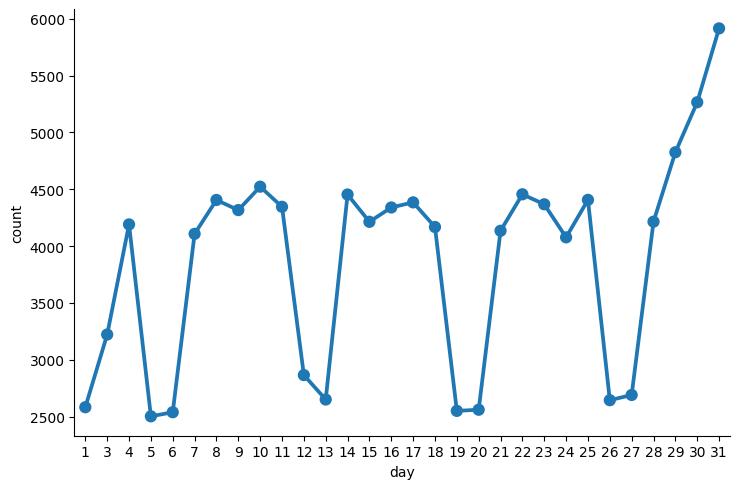

In [36]:
# Visualize the daily_hosts_df DataFrame
c = sns.catplot(
    x="day", y="count", data=daily_hosts_df, kind="point", height=5, aspect=1.5
)

### Average Number of Daily Requests per Host

In [37]:
# Calculate the average number of requests daily per Host
daily_hosts_df = (
    host_day_distinct_df.groupBy("day")
    .count()
    .select(col("day"), col("count").alias("total_hosts"))
)

In [38]:
total_daily_reqests_df = (
    df_parsed.select(F.dayofmonth("timestamp").alias("day"))
    .groupBy("day")
    .count()
    .select(col("day"), col("count").alias("total_reqs"))
)

In [39]:
avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, "day")
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.withColumn(
    "avg_reqs", col("total_reqs") / col("total_hosts")
).sort("day")

In [40]:
# Visualize the average daily requests per host
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,33996,2582,13.166538
1,3,41388,3222,12.845438
2,4,59557,4191,14.210690
3,5,31893,2502,12.747002
4,6,32420,2538,12.773838
5,7,57362,4108,13.963486
6,8,60157,4406,13.653427
7,9,60458,4317,14.004633
8,10,61248,4523,13.541455
9,11,61246,4346,14.092499


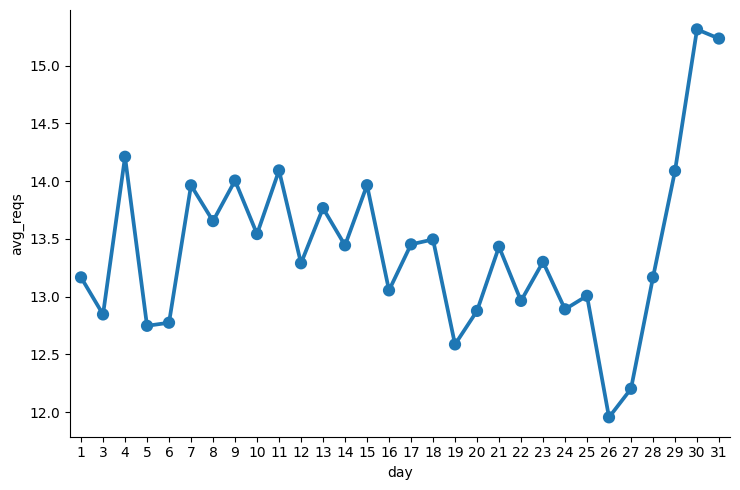

In [41]:
c = sns.catplot(
    x="day",
    y="avg_reqs",
    data=avg_daily_reqests_per_host_df,
    kind="point",
    height=5,
    aspect=1.5,
)

### Counting 404 Response Codes

In [42]:
# Analyze 404 response codes
not_found_df = df_parsed.filter(df_parsed["status"] == 404).cache()
print(("Total 404 responses: {}").format(not_found_df.count()))

Total 404 responses: 10056


### Top Twenty 404 Response Code Endpoints

In [43]:
# Analyze top 20 endpoints causing 404 errors
endpoints_404_count_df = (
    not_found_df.groupBy("endpoint").count().sort("count", ascending=False).limit(20)
)

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |1337 |
|/pub/winvn/release.txt                                           |1185 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |682  |
|/images/nasa-logo.gif                                            |319  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |251  |
|/elv/DELTA/uncons.htm                                            |209  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |200  |
|/://spacelink.msfc.nasa.gov                                      |166  |
|/images/crawlerway-logo.gif                                      |160  |
|/history/apollo/a-001/a-001-patch-small.gif                      |154  |
|/history/apollo/pad-abort-test-1/pad-

### Top Twenty 404 Response Code Hosts

In [44]:
# Analyze top 20 hosts causing 404 errors
hosts_404_count_df = (
    not_found_df.groupBy("host").count().sort("count", ascending=False).limit(20)
)

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|dialip-217.den.mmc.com     |62   |
|piweba3y.prodigy.com       |47   |
|155.148.25.4               |44   |
|maz3.maz.net               |39   |
|gate.barr.com              |38   |
|ts8-1.westwood.ts.ucla.edu |37   |
|m38-370-9.mit.edu          |37   |
|nexus.mlckew.edu.au        |37   |
|204.62.245.32              |37   |
|scooter.pa-x.dec.com       |35   |
|reddragon.ksc.nasa.gov     |33   |
|www-c4.proxy.aol.com       |32   |
|piweba5y.prodigy.com       |31   |
|piweba4y.prodigy.com       |30   |
|www-d4.proxy.aol.com       |30   |
|internet-gw.watson.ibm.com |29   |
|unidata.com                |28   |
|163.206.104.34             |28   |
|spica.sci.isas.ac.jp       |27   |
|www-d2.proxy.aol.com       |26   |
+---------------------------+-----+



### Visualizing 404 Errors per Day

In [45]:
# Visualize 404 errors by day
errors_by_date_sorted_df = (
    not_found_df.groupBy(F.dayofmonth("timestamp").alias("day")).count().sort("day")
)

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,243
1,3,304
2,4,346
3,5,236
4,6,373
5,7,537
6,8,391
7,9,279
8,10,315
9,11,263


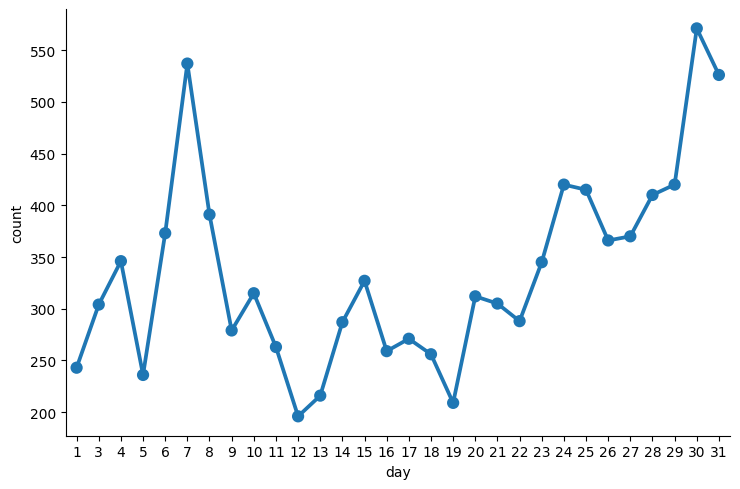

In [46]:
c = sns.catplot(
    x="day",
    y="count",
    data=errors_by_date_sorted_pd_df,
    kind="point",
    height=5,
    aspect=1.5,
)

### Top Three Days for 404 Errors

In [47]:
# Identify the three days with the most 404 errors
(errors_by_date_sorted_df.sort("count", ascending=False).show(3))

+---+-----+
|day|count|
+---+-----+
| 30|  571|
|  7|  537|
| 31|  526|
+---+-----+
only showing top 3 rows



### Visualizing Hourly 404 Errors

In [48]:
# Visualize 404 errors by hour
hourly_avg_errors_sorted_df = (
    not_found_df.groupBy(F.hour("timestamp").alias("hour")).count().sort("hour")
)
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

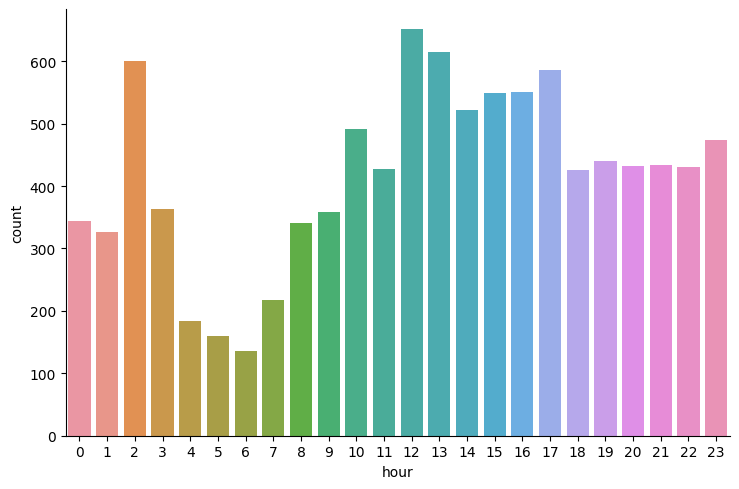

In [49]:
c = sns.catplot(
    x="hour",
    y="count",
    data=hourly_avg_errors_sorted_pd_df,
    kind="bar",
    height=5,
    aspect=1.5,
)

### 3.1 Generate the output presenting the endpoint that received the highest number of invocations on a specific day of the week, along with the corresponding count of invocations. (Summarize this for the entire dataset)
#### 3.1.1 Output:
#### Day in a week: Day in a week
#### Endpoint: endpoint which was invoked the most.
#### Count: Number of times it's been invoked
#### 3.1.2 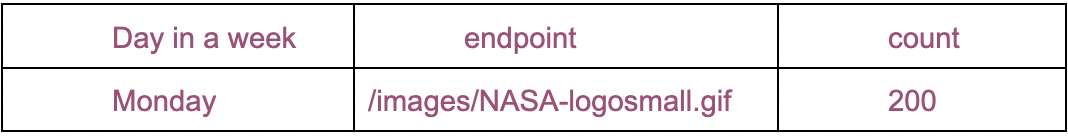

In [50]:
# Find the most frequently accessed endpoint for each day of the week
df_parsed = df_parsed.withColumn("day_of_week", F.date_format("timestamp", "E"))

In [51]:
df_grouped = df_parsed.groupBy("day_of_week", "endpoint").count()

In [52]:
window = Window.partitionBy("day_of_week").orderBy(F.desc("count"))
df_result = df_grouped.withColumn("rn", F.row_number().over(window)).filter(
    F.col("rn") == 1
)

In [53]:
df_result.select("day_of_week", "endpoint", "count").show()

+-----------+--------------------+-----+
|day_of_week|            endpoint|count|
+-----------+--------------------+-----+
|        Fri|/images/NASA-logo...|14178|
|        Mon|/images/NASA-logo...|13737|
|        Sat|/images/KSC-logos...| 6888|
|        Sun|/images/KSC-logos...| 6651|
|        Thu|/images/NASA-logo...|21762|
|        Tue|/images/NASA-logo...|17624|
|        Wed|/images/NASA-logo...|17167|
+-----------+--------------------+-----+



### 3.2 Total number of 404 status codes generated in each day of a week(For Monday, Tuesday,..… Sunday) for the entire dataset.

In [54]:
# Filter for the rows with status code 404
df = df_parsed.filter(F.col("status") == 404)

# Group by the day of the week and count the number of rows
df_grouped = df.groupBy("day_of_week").count()

# Display the result
df_grouped.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|        Sun| 1271|
|        Mon| 1539|
|        Thu| 1836|
|        Sat| 1007|
|        Wed| 1454|
|        Tue| 1669|
|        Fri| 1280|
+-----------+-----+

